In [47]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pathresults = "../../results/"
#pathresults = "/DUMUXDune27/DUMUX/dumux-rosi/python/paperSc/results/"
data_file_delimiter = ","


df = pd.read_pickle("./pset3_06mm.pkl")  # cid, pSet, rr, 1 or 9

In [48]:

#outputvalsname =  ['wat','cs','cl','coa','cod','cca','ccd','css2','co2','yX','yY','yZ']
#column_names = outputvalsname + paramsets.columns.tolist()
def getnewval_cell(df):
    #outputvalsname =  ['wat','cs','cl','coa','cod','cca','ccd','css2','co2','yX','yY','yZ']
    #column_names = outputvalsname + paramsets.columns.tolist()
    for konzz in ['theta','coa','cod','cca','ccd','css','co2']:
        df[konzz] = df['partialQ_'+konzz]/df['partial_volume']
    for konzz in ['cs','cl']:
        df[konzz] = df['partialQ_'+konzz+'soil']/df['partialQ_theta']#/df['partial_volume']
    df['vols'] = df['partial_volume']
    df['wat'] = df['partialQ_theta']
    try:
        df['css']=df['css2']
    except:
        pass
    df['cxd']=df['cod']+df['ccd']
    df['cxa']=df['coa']+df['cca']
    df['co'] = df['cod']+df['coa']
    df['cc'] = df['ccd']+df['cca']
    df['cx']=df['co']+df['cc']
    df['cxd_cx']=df['cxd']/df['cx']
    df['cxa_cx']=df['cxa']/df['cx']
     

    try:
        df['theta']=df['wat']/df['vols']
    except:
        try:
            df['theta']=df['wat']/df['vol']
        except:
            pass
        pass
    #df  = pd.merge(df, paramsets[['pSet', 'theta_th']], on="pSet")
    #df['csBis'] = df['cs']*df['theta']/df['theta_th']
    #df['clBis'] = df['cl']*df['theta']/df['theta_th']
    # per unit of soil volume
    df['cs_'] = df['cs']*df['theta']
    df['cl_'] = df['cl']*df['theta']
    df['soc']=df['cs_']+df['css']+df['cl_']+df['cx'] # df['socinit']
    #df.loc[df['scenario'] == "earlyDry",'scenario']="earlyDry"  # Select subset where 'pSet' equals the current value
    
    solidDensity = 2650 # [kg/m^3 solid] #taken from google docs TraiRhizo
    solidMolarMass = 60.08e-3 # [kg/mol] 
    thetaS= 0.43
    mgC_per_molC=12.011*1000
    
    massBulkDensity = solidDensity*(1.- thetaS) *1000 /1e6 # [kg/m^3 scv] * [g/kg] * [m3/cm3] = g/cm3
    print('massBulkDensity',massBulkDensity)
    #df['pSet']=df['scenario']+'_'+df['pSet']

    bulkD = massBulkDensity# g/cm3 soil * kg/g
    MmassC = 12.011 # gC/molC
    clay = 0.178*1000 # g/g to g/kg
    SOCexp = (clay*0.0288+13.674) / MmassC * bulkD/1000  # g C / kg soil => mol C/cm3 soil
    SOCreal = 0.0112/MmassC *bulkD# g/g => molC/cm3 soil, https://acsess.onlinelibrary.wiley.com/doi/10.2136/vzj2017.08.0152

    initSOC  ={'5':0.000261564277948825, '44':0.0002941431464338718, '61':0.0002833083349901329} # obtained from simulation
    
    df['socinit'] = [initSOC[pipi] for pipi in df['pSet']]
    df['socadded'] = SOCreal - df['socinit']
    df['socadapted'] = df['socadded'] + df['soc']
    # mol/cm3 scv to mg C pool/g C mineral
    if False:
        for nnn in ['cs_','cl_','co','cc','coa','cod','cca','ccd','css']:
            # mol C/cm3 *  
            df[nnn+'_mass'] = df[nnn]*mgC_per_molC / massBulkDensity
    return df
dfmean = getnewval_cell(df)
dfmean['pSetscenario']=np.char.add(np.array(dfmean['pSet'],dtype=str),np.array(dfmean['scenario'],dtype=str))

massBulkDensity 1.5105000000000002


In [49]:
dfmeanTot = dfmean.groupby(["time", "scenario", "pSet"])[  ['partialQ_'+konzz for konzz in ['cssoil','clsoil','coa','cod','cca','ccd','css','co2']]].agg('sum').reset_index()

In [50]:
dfmeanTot['totC'] = dfmeanTot[  ['partialQ_'+konzz for konzz in ['cssoil','clsoil','coa','cod','cca','ccd','css','co2']] ].sum(axis=1)

In [51]:
dfmeanTotrel = dfmeanTot.copy()
dfmeanTotrel[['totC'] + [
    'partialQ_'+konzz for konzz in ['cssoil','clsoil','coa','cod','cca','ccd','css','co2']] 
            ] =dfmeanTotrel[['totC'] + ['partialQ_'+konzz for konzz in ['cssoil','clsoil','coa','cod','cca','ccd','css','co2']] ].div(dfmeanTot['totC'], axis=0)

In [52]:
dfmeanTotrel['pSetscenario'] = dfmeanTotrel['pSet']+dfmeanTotrel['scenario']
dfmeanTotrel['microbes'] = dfmeanTotrel[ ['partialQ_'+konzz for konzz in ['coa','cod','cca','ccd']]].sum(axis=1)
dfmeanTotrel['solutes'] = dfmeanTotrel[ ['partialQ_'+konzz for konzz in ['cssoil','clsoil','css']]].sum(axis=1)
dfmeanTotrel['$CO_2$'] =  dfmeanTotrel['partialQ_co2']

In [79]:
import string
def cumsum_and_plotAllcontentvstime(dataframe_,ylab=None, xlab=None,vividlim=-1,
                   dosave=False, doshow=True, savedir='./', saveName='myimage',
                                    legendLabel={},depVars=[],
                      sizerows=8,sizecols=6,colidLegend=0, rowidLegend=0):
    for extraText in [savedir]:
        if not os.path.exists(extraText):
            os.makedirs(extraText)

    
    dataframe = dataframe_.copy()

    # Loop for each subplot
    scenarios =np.array( ['baseline', 'earlyDry', 'lateDry'])
    pSets = np.array([5,44,61])
    
    pSetscenarios = dataframe['pSetscenario'].unique()
    ncols = len(scenarios)
    nrows = len(pSets)
        
    fig, ax = plt.subplots(nrows, ncols,figsize=(sizerows,sizecols)) 
    for psetScenario in pSetscenarios:
        
        df__ =dataframe[dataframe['pSetscenario']==psetScenario].copy().reset_index()

        rowid = np.where(int(df__['pSet'].unique()[0])==pSets)[0] 
        if ncols > 1:
            colid = np.where(df__['scenario'].unique()[0]==scenarios)[0] 
            ax_ = ax[rowid, colid][0]
        else:
            colid = 0
            ax_ = ax[rowid]
        
        
        allcc = ["#fc8d62","#66c2a5","#8da0cb"]
        widths= [1,1,1,1,1,1,1,1]
        addedVals = np.zeros(df__['time'].shape)
        for vivid, vivi in enumerate(depVars):

            ax_.plot(df__['time'],df__[vivi]+addedVals,
                     linewidth=widths[vivid],
                             label=f'{vivi}',
                             c=allcc[vivid],
                             #linestyle=l_styles[int(df__['pSet'].unique()[0])]
                    )
            if vivid > vividlim:
                ax_.fill_between(df__['time'],addedVals,df__[vivi].values+addedVals ,color=allcc[vivid])
            addedVals += df__[vivi].values

        
        if (rowid==2) and (colid==1):
            ax_.set_xlabel(xlab, fontsize=20)#'maximum '+independent_variable+' (mol/cm3 water)')
        if (colid==0):
            if (rowid==1):
                ax_.set_ylabel(ylab+"\n"+"parameter set "+df__['pSet'].unique()[0], fontsize=20)
            else:
                ax_.set_ylabel("\n"+"parameter set "+df__['pSet'].unique()[0], fontsize=20)
                
                
        ax_.tick_params(axis='both', which='major', labelsize=18)


        if df__['scenario'].unique()[0] == "lateDry":
            ax_.axvline(x=18, color='k', linestyle='--')
            ax_.axvline(x=25, color='k', linestyle='--')
        if df__['scenario'].unique()[0] == "earlyDry":
            ax_.axvline(x=18, color='k', linestyle='--')
            ax_.axvline(x=11, color='k', linestyle='--')



        # Remove tick labels
        if rowid < 2:
            ax_.set_xticklabels([])
        if colid > 0:
            ax_.set_yticklabels([])
            
        ax_.grid(True)
        if (rowid==0):
            ax_.set_title(df__['scenario'].unique()[0], fontsize=20)
                
        if (colid == colidLegend) and (rowid==rowidLegend):
            handles, labels = ax_.get_legend_handles_labels()
            thick_handles = [plt.Line2D([], [], color=handle.get_color(), linewidth=6) for handle in handles]
            ax_.legend(thick_handles, labels, fontsize=20,title_fontsize='25', title='carbon pool')
            #ax_.legend(fontsize=20,title_fontsize='25', title='carbon pool')
            
        
        # Get the corresponding letter label
        label = string.ascii_uppercase[(rowid*ncols+colid)[0]]
        ax_.annotate(
                label,
                xy=(0, 1.12), xycoords='axes fraction',
                xytext=(+0.5, -0.5), textcoords='offset fontsize',
                fontsize='20', verticalalignment='top', fontfamily='serif',
                bbox=dict(facecolor='1.', edgecolor='none', pad=3.0))
        
    plt.tight_layout()  
    plt.grid(True)
    if dosave:
        plt.savefig(savedir+saveName+'.png', pad_inches=0.5)
    if doshow:
        plt.show()
    plt.close()

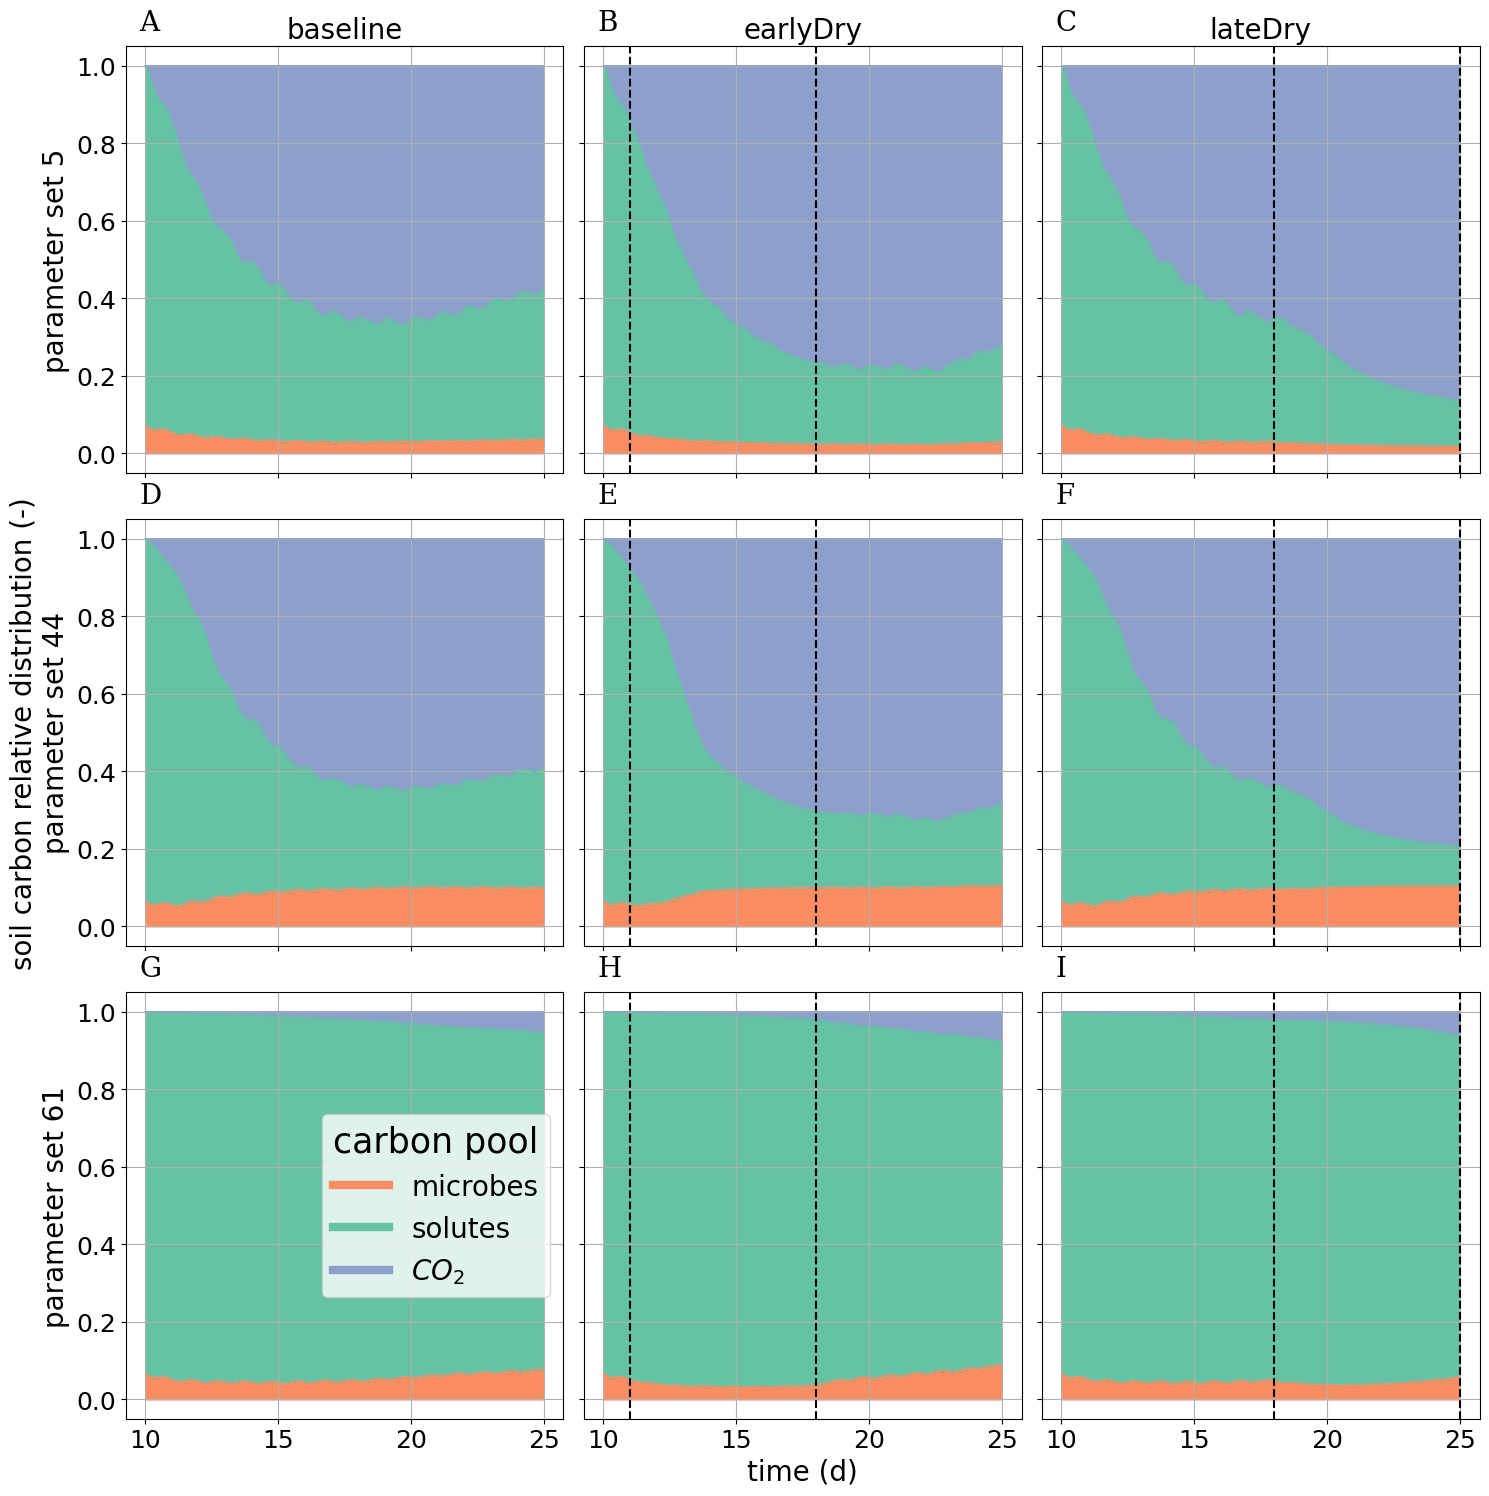

In [80]:
cumsum_and_plotAllcontentvstime(dataframe_=dfmeanTotrel,
                                ylab="soil carbon relative distribution (-)",
                                xlab="time (d)",
                   dosave=True, doshow=True, savedir='./', 
                                saveName='relpooldistribRhizo',vividlim=-1,
                                    legendLabel={},
                                depVars= ['microbes','solutes','$CO_2$'],
                      sizerows=15,sizecols=15,colidLegend=0, rowidLegend=2)

In [74]:
dfbulksoil = pd.read_pickle('./soil3dData.pkl')
dfbulksoil = dfbulksoil[dfbulksoil['gotR']].copy().reset_index()
dfbulksoil[[ 'cs', 'cl']
           ] =dfbulksoil[[ 'cs', 'cl'] ].mul(dfbulksoil['theta'], axis=0)
dfbulksoil[[ 'cs', 'css','cl','cc','co','co2' ]
           ] =dfbulksoil[[ 'cs', 'css','cl','cc','co' ,'co2'] ].mul(dfbulksoil['volscv'], axis=0)
dfbulksoil['totC']=dfbulksoil[[ 'cs', 'css','cl','cc','co','co2' ] ].sum(axis=1)
dfbulksoil = dfbulksoil.groupby(["time", "scenario", "pSet"])[ [ 'cs', 'css','cl','cc','co','co2','totC' ] ].agg('sum').reset_index()


dfbulksoilrel = dfbulksoil.copy()
dfbulksoilrel[ [ 'cs', 'css','cl','cc','co','co2','totC' ] 
            ] =dfbulksoilrel[ [ 'cs', 'css','cl','cc','co','co2','totC' ]  ].div(dfbulksoil['totC'], axis=0)

dfbulksoilrel['microbes'] = dfbulksoilrel[ ['co','cc']].sum(axis=1)
dfbulksoilrel['solutes'] = dfbulksoilrel[ ['cs', 'css','cl']].sum(axis=1)
dfbulksoilrel['$CO_2$'] =  dfbulksoilrel['co2']

In [75]:

dfbulksoilrel['pSetscenario'] =np.array( dfbulksoilrel['pSet'], dtype=str)+dfmeanTotrel['scenario']

In [76]:
dfbulksoilrel['pSet']=dfbulksoilrel['pSet'].astype(str)

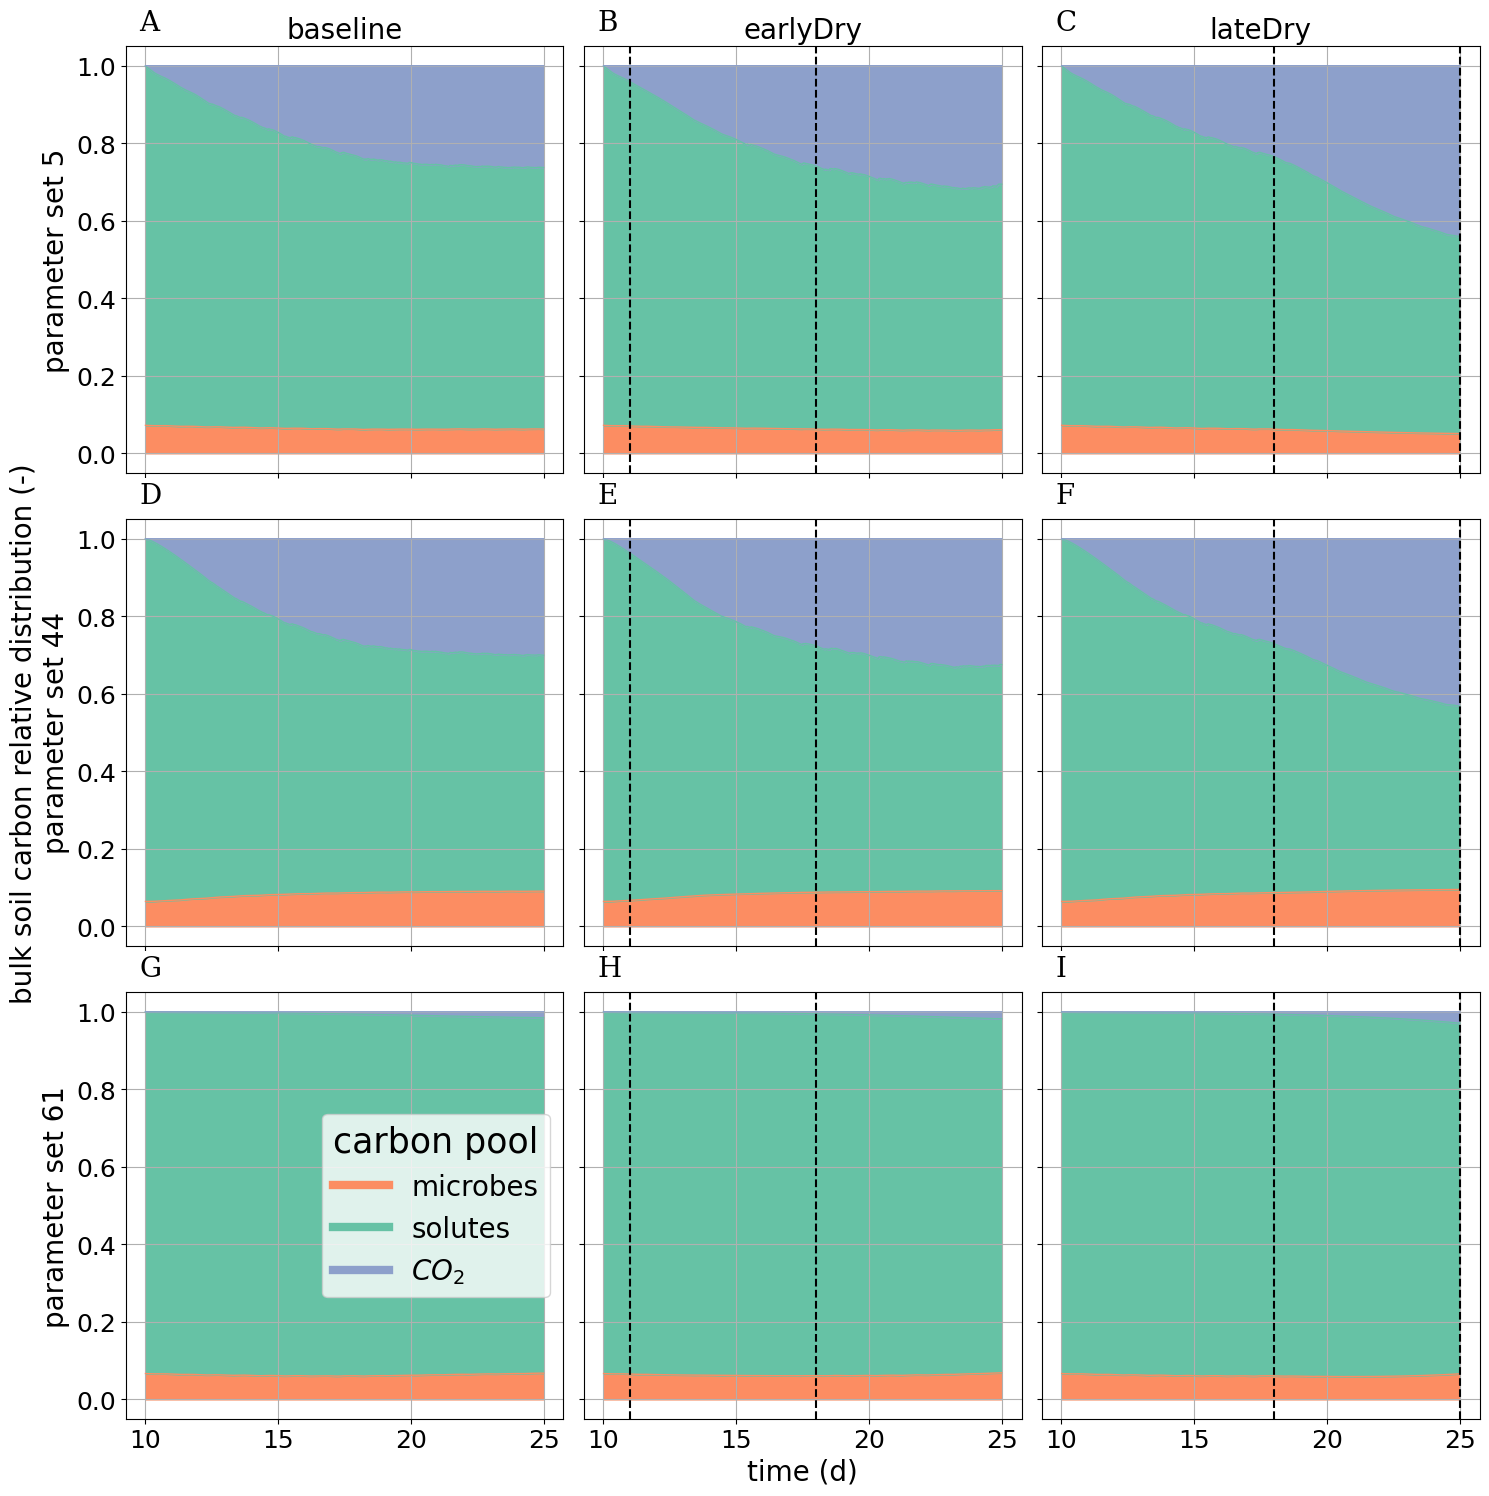

In [81]:
cumsum_and_plotAllcontentvstime(dataframe_=dfbulksoilrel,
                                ylab="bulk soil carbon relative distribution (-)",
                                xlab="time (d)",
                   dosave=True, doshow=True, savedir='./', 
                                saveName='relpooldistribBulk',vividlim=-1,
                                    legendLabel={},
                                depVars= ['microbes','solutes','$CO_2$'],
                      sizerows=15,sizecols=15,colidLegend=0, rowidLegend=2)

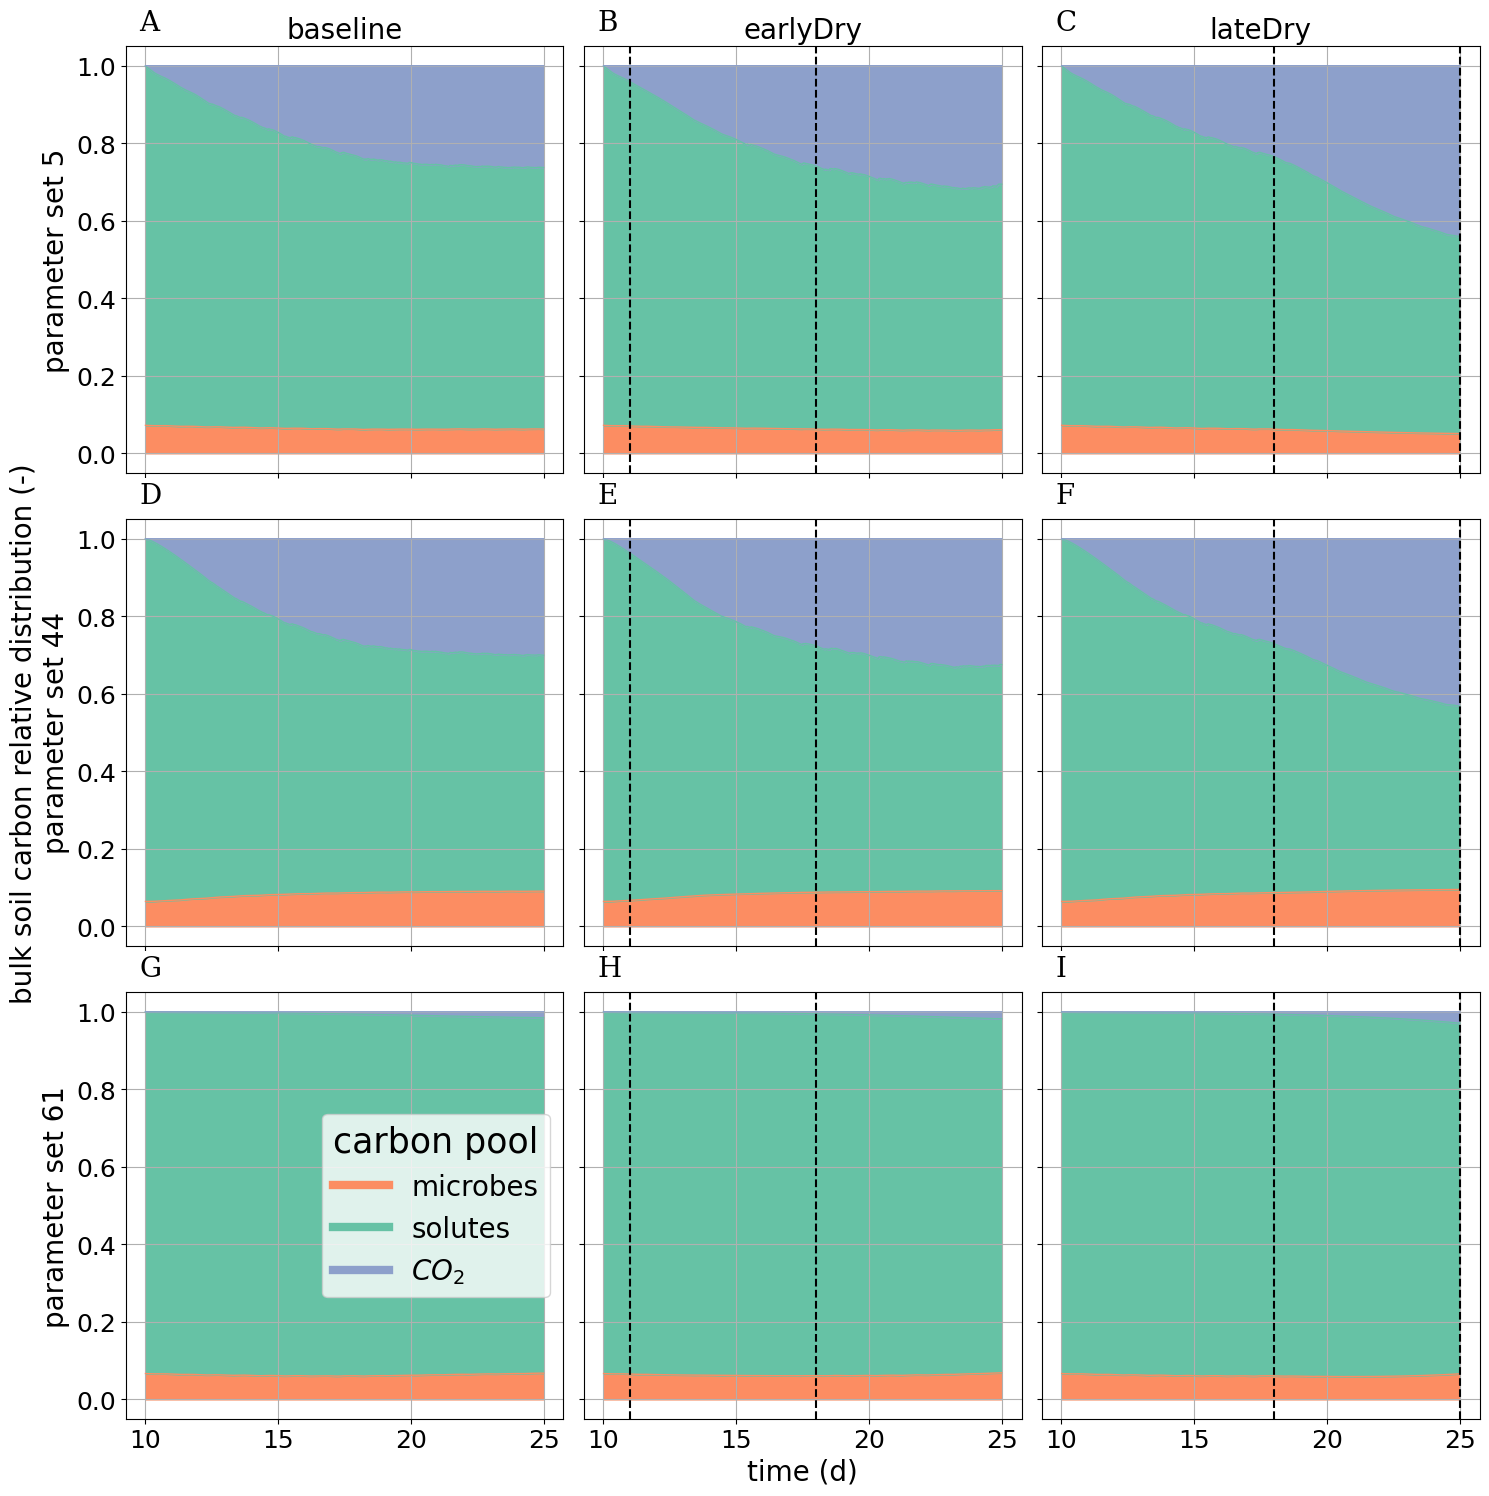

In [82]:
cumsum_and_plotAllcontentvstime(dataframe_=dfbulksoilrel,
                                ylab="bulk soil carbon relative distribution (-)",
                                xlab="time (d)",
                   dosave=True, doshow=True, savedir='./', 
                                saveName='relpooldistribBulk',vividlim=-1,
                                    legendLabel={},
                                depVars= ['microbes','solutes','$CO_2$'],
                      sizerows=15,sizecols=15,colidLegend=0, rowidLegend=2)